In [2]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
hate_data = pd.read_csv("hate_speech_binary_dataset.csv", delimiter=",") # 혐오 문장
genderbias_data = pd.read_csv('genderbias.csv', sep=',')  # 여성 비하 문장
ilbe_data = pd.read_csv('badword.csv',encoding='CP949') # 일베 문장

## 문장 전처리

In [4]:
# 혐오 문장 처리
hate_data.columns = ['comment', 'label'] # 컬럼 명 변경
hate_data = hate_data.astype({'comment': 'str'})
hate_data = hate_data[hate_data['label']==1]

In [5]:
# 여성 비하 문장 처리
del genderbias_data['bias']    #해당 데이터셋의 필요없는 열 제거
del genderbias_data['hate']    #해당 데이터셋의 필요없는 열 제거
genderbias_data['contain_gender_bias'] = genderbias_data['contain_gender_bias'].replace([False, True],[0,1])  # 구분하기 쉽게 기존의 표기를 0,1로 변경
# genderbias_data = genderbias_data[['contain_gender_bias', 'comments']]    #구분하기 쉽게 열의 순서를 변경

genderbias_data.columns = ['comment', 'label'] # 컬럼 명 변경
genderbias_data = genderbias_data[genderbias_data['label']==1]

In [6]:
# 일베 문장 처리
ilbe_data = ilbe_data[['v2', 'v1']]    #구분하기 쉽게 열의 순서를 변경
ilbe_data.columns = ['comment', 'label'] # 컬럼 명 변경
ilbe_data = ilbe_data[ilbe_data['label']==1]

In [7]:
# 데이터 개수
print("hate_data : %d" % len(hate_data))
print("genderbias_data : %d" % len(genderbias_data))
print("ilbe_data : %d" % len(ilbe_data))

hate_data : 100000
genderbias_data : 1232
ilbe_data : 2044


## 라벨링 및 합치기

In [8]:
# 렌덤하게 문장 추출 후 라벨링 거치는 함수
def random_labeling(data, classified_data, label_num, str_num):  # label_num : 라벨링 시킬 값, str_num 추출할 문장 개수
    random_data = classified_data.sample(n=str_num) # str_num 개의 행(문장) 랜덤 추출
    random_data.loc[random_data.label == 1, 'label'] = label_num # label_num으로 값 변경
    data = data.append(random_data)  # data 에 랜덤 추출된 데이터 추가
    return data

In [9]:
data_declaration = {
    'comment' : ["str_Declaration"],
    'label':[-1]
}


data = pd.DataFrame(data_declaration)
data

,comment,label
0,str_Declaration,-1


In [10]:
# 문장 개수를 모두 2000 개로 지정 각 
# 라벨은 혐오:0, 여성비하: 1, 일베: 2로 지정됨
data = random_labeling(data, hate_data, 0, 2000)
data = random_labeling(data, genderbias_data, 1, 1200)
data = random_labeling(data, ilbe_data, 2, 2000)

In [11]:
# 첫번째 행 제거
data = data.drop(0)

In [12]:
# 랜덤하게 섞기 
data = data.sample(frac=1).reset_index(drop=True)

In [13]:
data[:10]

,comment,label
0,쿵쾅이들이 또오오?,1
1,꺼져,2
2,나도 75인치 사려고...요새 플스하는데 화면 좆만해보여서,2
3,어흐흐 넘 잼있게 봤어요! 역시 아카데미 오스카상을 받을만한 만화영화내요. 아주오랜...,0
4,"은퇴 기념으로 야동찍으러 가야겠군,,, ㅋㅋㅋ 연예계 왜년들의 최종 생계수단은 야동...",1
5,딸이랑 피부랑 직빵으로 연결되있다,2
6,줌마들 밥은 하고 댓글 다나요??,1
7,본넷 열고 허리숙이고 엔진룸보는 자세에서 뒤에서바로 벨트풀고싶었다 물론 팬벨트,1
8,꼴값떠네,2
9,여름방학때 이거보면서 즐거웠는데 ㅎ,0


## 중복 및 null 처리

In [14]:
def detect_overlap(data):
    exist_overlap = len(data)  # 데이터 전체 개수
    no_overlap = data['comment'].nunique()  # 중복 제거된 개수
    if exist_overlap != no_overlap:
        data.drop_duplicates(subset=['comment'], inplace=True)

In [15]:
detect_overlap(data)

In [16]:
# null 값 확인
data.isnull().values.any()

False

## 토큰화

In [17]:
def tokenize(x_data, tokenizer):
    tokenizer.fit_on_texts(x_data) # 데이터의 각 행별로 토큰화 수행
    return tokenizer.texts_to_sequences(x_data)    

In [18]:
x_data = data['comment']
y_data = data['label']

In [19]:
tokenizer = Tokenizer()
sequences = tokenize(x_data, tokenizer)

## 희귀단어 확인

In [20]:
def detect_rareword(tokenizer, threshold):
    word_to_index = tokenizer.word_index 
    total_cnt = len(word_to_index) # 단어의 수
    rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
    total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
    rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

    # 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
    for key, value in tokenizer.word_counts.items():
        total_freq = total_freq + value

        # 단어의 등장 빈도수가 threshold보다 작으면
        if(value < threshold):
            rare_cnt = rare_cnt + 1
            rare_freq = rare_freq + value

    print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
    print("단어 집합(vocabulary)에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
    print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)
    

In [21]:
# 희귀 단어 확인
detect_rareword(tokenizer, 2)

등장 빈도가 1번 이하인 희귀 단어의 수: 23243
단어 집합(vocabulary)에서 희귀 단어의 비율: 83.30227223854921
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 48.842145078591244


## 훈련 데이터, 테스트 데이터 분리

In [22]:
# 가장 긴 길이
def max_length(X_data):
    return max(len(l) for l in X_data)

# 훈련 학습 데이터 개수
def num_dataset(raio, X_data):
    num_train = int(len(X_data)*0.8)
    num_test = int(len(X_data) - num_train)
    return num_train, num_test

# 훈련 및 학습 데이터 분리
def config_dataset(num_train, data):
    X_test = data[num_train:] #X_data 데이터 중에서 뒤의 개의 데이터만 저장
    y_test = np.array(y_data[num_train:]) #y_data 데이터 중에서 뒤의 개의 데이터만 저장
    X_train = data[:num_train] #X_data 데이터 중에서 앞의 n_of_train개의 데이터만 저장
    y_train = np.array(y_data[:num_train]) #y_data 데이터 중에서 앞의 n_of_train개의 데이터만 저장
    
    return X_test, y_test, X_train, y_train

In [23]:
# 최대 길이 계산
X_data = sequences
maxlen = max_length(X_data)

## 문장 길이 분포 확인

문장 최대 길이 : 194
문장 평균 길이 : 9.193972


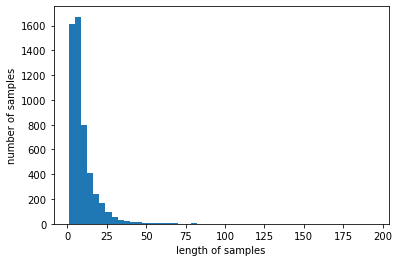

In [24]:
print('문장 최대 길이 : %d' % max(len(l) for l in X_data))
print('문장 평균 길이 : %f' % (sum(map(len, X_data))/len(X_data)))
plt.hist([len(s) for s in X_data], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

## 훈련 데이터, 학습 데이터 분할

In [25]:
# 훈련 및 학습 데이터 개수 비율 지정
numtrain, numtest = num_dataset(0.8, X_data)

In [26]:
# 가장 긴 길이로 맞추기
data = pad_sequences(X_data, maxlen = maxlen)

In [27]:
X_test, y_test, X_train, y_train = config_dataset(numtrain, data)

## 모델 학습

In [93]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import datasets
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dropout, Conv1D, GlobalMaxPooling1D, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import pandas as pd
import tensorflow.keras.metrics 

In [94]:
size = 1000000
model = Sequential()
model.add(Embedding(size , 64, input_length = maxlen)) #워드 임베딩
model.add(Dropout(0.5)) #과적합 방지를 위해 일부 Drop, 기본 50% 정도를 Drop하도록 설정함.
model.add(Conv1D(64, 3, padding='valid', activation='relu')) #hidden layer 추가
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.5)) #과적합 방지를 위해 일부 Drop, 기본 50% 정도를 Drop하도록 설정함.
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5)) #과적합 방지를 위해 일부 Drop, 기본 50% 정도를 Drop하도록 설정함.
num_of_class = 3 #클래스는 우선 4개로 분류함
model.add(Dense(num_of_class, activation='linear'))
##model.add(Dense(num_of_class, activation='softmax')) #마지막 레이어는 softmax로 출력하게 함
model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 194, 64)           64000000  
_________________________________________________________________
dropout_33 (Dropout)         (None, 194, 64)           0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 192, 64)           12352     
_________________________________________________________________
global_max_pooling1d_11 (Glo (None, 64)                0         
_________________________________________________________________
dropout_34 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_25 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_35 (Dropout)         (None, 64)              

In [96]:
model.compile(optimizer='adam', loss=SparseCategoricalCrossentropy(from_logits=True),metrics= ["accuracy"])
es = EarlyStopping(monitor='loss', mode='min' , min_delta=0)
check_point = ModelCheckpoint('best_model.h5', monitor='loss', mode='min', save_best_only=True)

## Training

In [97]:
hist = model.fit(X_train, y_train, batch_size = 16, epochs=10, callbacks=[es, check_point])

Epoch 1/10
259/259 [==============================] - 114s 440ms/step - loss: 1.0786 - accuracy: 0.3920
Epoch 2/10
259/259 [==============================] - 118s 455ms/step - loss: 0.9958 - accuracy: 0.4949
Epoch 3/10
259/259 [==============================] - 118s 455ms/step - loss: 0.6183 - accuracy: 0.7442
Epoch 4/10
259/259 [==============================] - 118s 456ms/step - loss: 0.2971 - accuracy: 0.9065
Epoch 5/10
259/259 [==============================] - 117s 451ms/step - loss: 0.1263 - accuracy: 0.9667
Epoch 6/10
259/259 [==============================] - 117s 452ms/step - loss: 0.0612 - accuracy: 0.9848
Epoch 7/10
259/259 [==============================] - 117s 451ms/step - loss: 0.0338 - accuracy: 0.9918
Epoch 8/10
259/259 [==============================] - 127s 491ms/step - loss: 0.0249 - accuracy: 0.9940
Epoch 9/10
259/259 [==============================] - 118s 456ms/step - loss: 0.0188 - accuracy: 0.9961
Epoch 10/10
259/259 [==============================] - 118s 454m

In [99]:
X_result = model.predict(X_test, batch_size = 16)
X_result

array([[-2.8286574 ,  2.5899694 , -0.2076825 ],
       [-2.257825  , -0.17833108,  2.0290878 ],
       [ 1.632132  , -2.0337727 , -0.24073467],
       ...,
       [-2.458558  ,  1.0805383 ,  0.486537  ],
       [ 8.538113  , -6.538868  , -4.294672  ],
       [-3.0496917 , -1.7211909 ,  4.1435905 ]], dtype=float32)

In [100]:
model2 = Sequential()
model2.add(Dense(num_of_class, activation = 'softmax'))
model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics= ["accuracy"])

In [101]:
model2.fit(X_result, y_test, batch_size = 16, epochs = 1, callbacks = [es, check_point])

65/65 [==============================] - 0s 446us/step - loss: 8.3492 - accuracy: 0.1506


In [102]:
model2.predict(X_result, batch_size = 16)

array([[9.3154436e-01, 6.3436054e-02, 5.0196163e-03],
       [9.8472589e-01, 3.0898722e-03, 1.2184199e-02],
       [2.3720181e-02, 1.7289883e-01, 8.0338103e-01],
       ...,
       [9.6133554e-01, 2.6576282e-02, 1.2088262e-02],
       [1.2238535e-08, 5.8745597e-02, 9.4125444e-01],
       [9.9764889e-01, 3.8793743e-05, 2.3123573e-03]], dtype=float32)

## 결과 확인

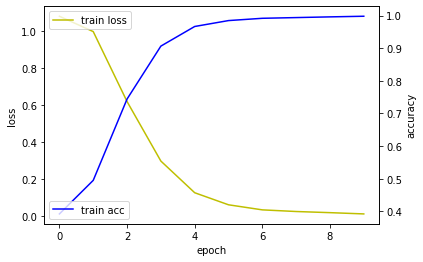

In [103]:
#모델 학습 과정 표시

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')

acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')


loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

In [108]:
class_result = []
for a,b,c in model.predict(X_test, batch_size=16):
    numbers = [a,b,c]
    class_result.append(numbers.index(max(numbers)))

In [109]:
result = pd.DataFrame(model.predict(X_test, batch_size=16),columns=['0', '1', '2'])
result["Test Label"] = y_test
result["Classification Result"] = class_result
result["Final Result"] = (y_test == class_result)

result.to_csv("test_result.csv")

In [110]:
print("테스트 정확도: %.4f" % (model.evaluate(X_test, y_test)[1]))

33/33 [==============================] - 0s 2ms/step - loss: 0.9651 - accuracy: 0.7133
테스트 정확도: 0.7133


## 모델 저장

In [36]:
##모델을 .json 파일 형식으로 save하여 저장
model_json = model.to_json()
with open("model.json", "w") as json_file : 
    json_file.write(model_json)
    
model.save_weights("model_weight.h5")
model.save('full_model.h5')

In [37]:
##모델 조정이 끝나면, Model을 사용 하여 OpenMax에 필요한 자료를 선정하여 OpenMax로 구현할 예정입니다.